In [1]:
# !pip install pytorch_lightning
# !pip install tensorboard

In [2]:
import os
import urllib.request
from copy import deepcopy
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import STL10
from tqdm.notebook import tqdm


In [3]:
plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.set()

<Figure size 640x480 with 0 Axes>

In [4]:
# Import tensorboard
%load_ext tensorboard

In [5]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/ContrastiveLearning/")
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()


In [6]:
pl.seed_everything(42)

Seed set to 42


42

In [7]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark=False

In [8]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cpu
Number of workers: 8


In [9]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# Files to download
pretrained_files = [
    "SimCLR.ckpt",
    "ResNet.ckpt",
    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
    "tensorboards/classification/ResNet/events.out.tfevents.ResNet",
]
pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder,"
                " or contact the author with the full output including the following error:\n",
                e,
            )

In [10]:
class ContrastiveTransformations:
    def __init__(self, base_transforms, n_views = 2):
        self.base_transforms = base_transforms
        self.n_views = n_views
    def __call__(self,x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [11]:
contrast_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
])

In [15]:
unlabeled_data = STL10(
    root = DATASET_PATH,
    split = "unlabeled",
    download=True,
    transform = ContrastiveTransformations(contrast_transform, n_views=2)
)

100%|██████████| 2640397119/2640397119 [10:12<00:00, 4312665.25it/s] 


Extracting data/stl10_binary.tar.gz to data/


In [16]:
train_data_contrast = STL10(
    root=DATASET_PATH,
    split="train",
    download=True,
    transform=ContrastiveTransformations(contrast_transform, n_views=2),
)

Files already downloaded and verified


Seed set to 42


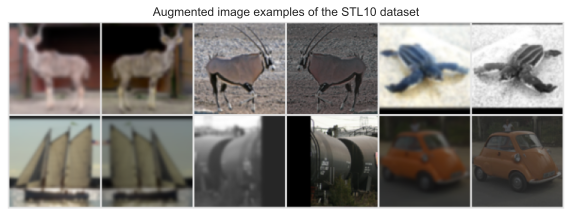

In [17]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the STL10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

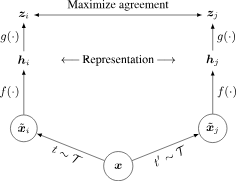

In [19]:
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, "The temperature must be a positive float!"
        #Base model f(.)
        self.convnet = torchvision.models.resnet18(pretrained=False, num_classes = 4*hidden_dim) #num_classes is the output size of the last linear layer
        #The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc, #Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim,hidden_dim),
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr = self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.hparams.max_epochs, eta_min = self.hparams.lr/50
        )
        return [optimizer], [lr_scheduler]
    
    def info_nce_loss(self, batch, mode="train"):
        imgs,_ = batch
        imgs = torch.cat(imgs, dim=0)

        #Encode all images
        feats = self.convnet(imgs)

        #Calculate the cosine similarity
        cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)

        #Mask out the cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)

        #Find +ve eg -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts = cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim/self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        #Logging loss
        self.log(mode+"_loss", nll)
        #Get ranking position of positive eg
        comb_sim = torch.cat(
            [cos_sim[pos_mask][:,None], cos_sim.masked_fill(pos_mask, -9e15)],
            dim=-1,
        )

        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+"_acc_top1", (sim_argsort==0).float().mean())
        self.log(mode+"_acc_top5", (sim_argsort<5).float().mean())
        self.log(mode+"_acc_mean_pos", 1+sim_argsort.float().mean())

        return nll

    def training_step(self,batch, batch_idx):
        return self.info_nce_loss(batch, mode="train")
    
    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode="val")